# Bank churn analysis

The ML model is focused on churn analysis for a financial institution. XAI techniques are also applied to enhance the understanding of the model.

### 📝 Project Summary
- This project focuses on customer churn prediction for a financial institution using a Random Forest classification model. The dataset, sourced from Kaggle, contains customer demographic and behavioral data.

To improve model performance, the following preprocessing steps were applied:

- Removal of customers with a zero balance, as their presence negatively impacted the model's ability to learn meaningful patterns.

- Dropping irrelevant columns to reduce noise and dimensionality.

- Transformation of categorical features (e.g., gender and country) using One-Hot Encoding for numerical compatibility.

- Normalization of numerical variables to ensure consistent scaling.

### 🔍 Feature Correlation & Selection
A correlation analysis revealed that Age, Germany (encoded country), and Number of Products had the strongest relationships with churn (Exited). These insights guided feature selection and model interpretation.

### 🧠 Model Training & Optimization
- The model was trained using the Random Forest algorithm, and hyperparameter tuning was performed with RandomizedSearchCV. The best model was obtained with 147 estimators and max_depth = 15.

- Although the model achieved high accuracy and precision, the moderate recall highlighted an opportunity to improve sensitivity in identifying all at-risk customers.

### 📈 Feature Importance & Explainability
- Age was the most influential feature, with a relative importance of 0.25.

- Balance, Credit Score, Estimated Salary, and Number of Products followed with importance scores between 0.10 and 0.15.

- Using LIME, it was observed that for customer 590, these variables were decisive in classifying them as a potential churner, with 94% confidence.

- Due to compatibility issues introduced in a recent update of the SHAP library with certain scikit-learn models, the explainability analysis was supplemented with churn probability outputs to better understand customer profiles based on demographic and behavioral attributes.

### 📊 Key Findings
- Age was the strongest predictor of churn (24.9% importance).

- Balance gained relevance after data cleaning.

- Other impactful features included Credit Score, Estimated Salary, and Number of Products.

- Analysis of categorical features and churn probability showed how being an inactive member, being female, being from Germany, and not having a credit card tend to be associated with higher churn risk.

## Data

### Import data

The dataset used is from Kaggle and focuses on customer churn in a bank. <br>
Link: [Churn Modelling](https://www.kaggle.com/datasets/shubh0799/churn-modelling)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [ ]:
base = pd.read_csv('/content/sample_data/Churn_Modelling.csv', sep=',')

In [ ]:
len(base)

10000

In [ ]:
base_prob = base.copy()

In [ ]:
base.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Remove Balance zero

Customers with a zero balance were removed, as the model performs better without zero-value data on the amounts customers keep in the bank.

In [ ]:
base = base[base['Balance'] != 0]

<Axes: >

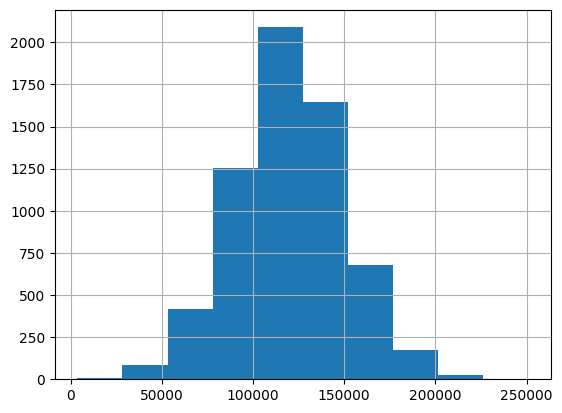

In [ ]:
base['Balance'].hist()

In [ ]:
base.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1


In [ ]:
base.isna().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6383 entries, 1 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        6383 non-null   int64  
 1   CustomerId       6383 non-null   int64  
 2   Surname          6383 non-null   object 
 3   CreditScore      6383 non-null   int64  
 4   Geography        6383 non-null   object 
 5   Gender           6383 non-null   object 
 6   Age              6383 non-null   int64  
 7   Tenure           6383 non-null   int64  
 8   Balance          6383 non-null   float64
 9   NumOfProducts    6383 non-null   int64  
 10  HasCrCard        6383 non-null   int64  
 11  IsActiveMember   6383 non-null   int64  
 12  EstimatedSalary  6383 non-null   float64
 13  Exited           6383 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 748.0+ KB


Dropping irrelevant columns

In [ ]:
base.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

### One Hot Encoding

Key categorical features, such as gender and country, were transformed into numerical representations using one-hot encoding to ensure compatibility with machine learning algorithms.

In [ ]:
def hot_encoder(base, column):
  # Separate the column for one hot
  categorical_attributes = [column]
  categorical_columns = base[categorical_attributes]
  # instance and train OneHotEncoder
  encoder = OneHotEncoder(handle_unknown='ignore')
  encoder.fit(categorical_columns)
  # Codify the categorical columns and transform in a dataframe
  encoded = encoder.transform(categorical_columns).toarray()
  enc_train = pd.DataFrame(data = encoded, columns = encoder.categories_)
  # Concat with the original dataframe and drop original column
  base = pd.concat([base,enc_train],axis=1)
  base.drop(categorical_attributes, axis=1, inplace=True)
  return base

In [ ]:
base = hot_encoder(base, 'Gender')
base.rename(columns={base.iloc[:,10].name: 'Female', base.iloc[:,11].name: 'Male'}, inplace=True)
base.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male
1,608.0,Spain,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,1.0,0.0
2,502.0,France,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,1.0,0.0
4,850.0,Spain,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,1.0,0.0
5,645.0,Spain,44.0,8.0,113755.78,2.0,1.0,0.0,149756.71,1.0,0.0,1.0
7,376.0,Germany,29.0,4.0,115046.74,4.0,1.0,0.0,119346.88,1.0,0.0,1.0


In [ ]:
base = pd.get_dummies(base, columns=['Geography'], prefix="Country")
base.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,Country_France,Country_Germany,Country_Spain
1,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,1.0,0.0,False,False,True
2,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,1.0,0.0,True,False,False
4,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,1.0,0.0,False,False,True
5,645.0,44.0,8.0,113755.78,2.0,1.0,0.0,149756.71,1.0,0.0,1.0,False,False,True
7,376.0,29.0,4.0,115046.74,4.0,1.0,0.0,119346.88,1.0,0.0,1.0,False,True,False


In [ ]:
def binary_values(base, column):
  base[column] = base[column].map({True: 1, False: 0})
  return base

In [ ]:
for i, c in enumerate(base.columns):
  if i >= 11:
    binary_values(base, c)
base.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,Country_France,Country_Germany,Country_Spain
1,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,1.0,0.0,0,0,1
2,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,1.0,0.0,1,0,0
4,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,1.0,0.0,0,0,1
5,645.0,44.0,8.0,113755.78,2.0,1.0,0.0,149756.71,1.0,0.0,1.0,0,0,1
7,376.0,29.0,4.0,115046.74,4.0,1.0,0.0,119346.88,1.0,0.0,1.0,0,1,0


In [ ]:
data_train = base

### MinMaxScaler

Feature scaling was applied to normalize the data, ensuring that all variables are on a comparable scale for optimal model performance.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data_train[columns_to_scale] = scaler.fit_transform(data_train[columns_to_scale])

In [ ]:
data_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,Country_France,Country_Germany,Country_Spain
1,0.516,0.310811,0.1,0.323876,0.000000,0.0,1.0,0.562770,0.0,1.0,0.0,0,0,1
2,0.304,0.324324,0.8,0.630812,0.666667,1.0,0.0,0.569716,1.0,1.0,0.0,1,0,0
4,1.000,0.337838,0.2,0.492625,0.000000,1.0,1.0,0.395443,0.0,1.0,0.0,0,0,1
5,0.590,0.351351,0.8,0.445059,0.333333,1.0,0.0,0.748879,1.0,0.0,1.0,0,0,1
7,0.052,0.148649,0.4,0.450283,1.000000,1.0,0.0,0.596798,1.0,0.0,1.0,0,1,0


### Correlation Analysis of Variables

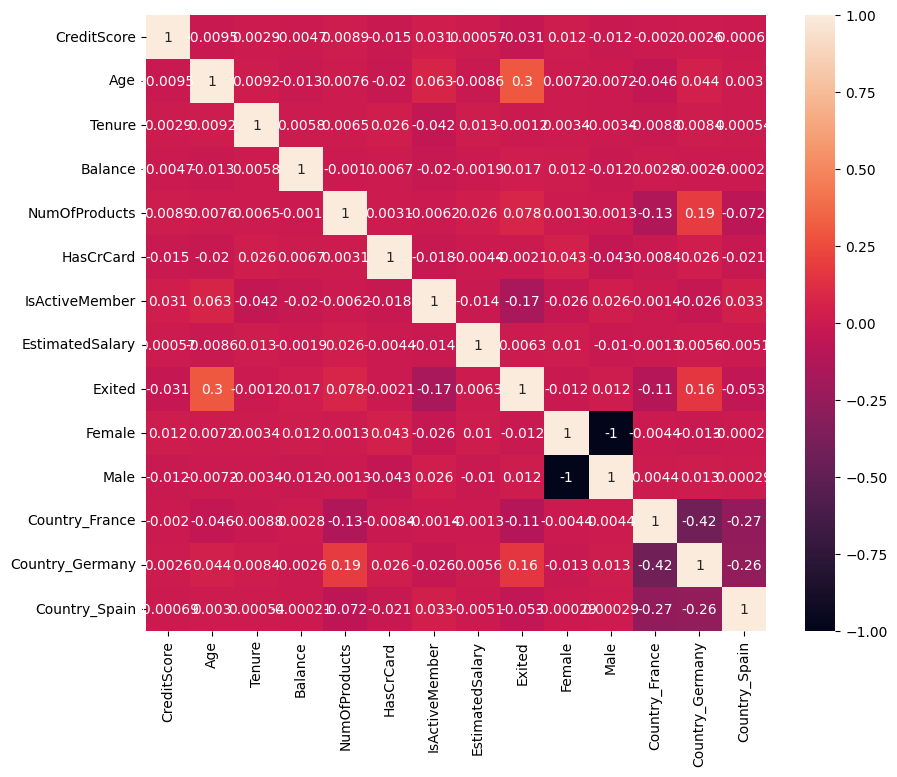

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = data_train.corr()

# Create the heatmap
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [ ]:
data_train.corr()['Exited'].sort_values(ascending=False)

,Exited
Exited,1.000000
Age,0.301554
Country_Germany,0.157420
NumOfProducts,0.077910
Balance,0.017208
Male,0.011541
EstimatedSalary,0.006335
Tenure,-0.001221
HasCrCard,-0.002135
Female,-0.011541


Examining the correlation matrix, the features most strongly associated with churn (Exited) are Age, the country encoded as a numeric variable for Germany, and the number of products the customer uses within the bank.

In [ ]:
data_train.dropna(inplace=True)

## Train Model

For model training, the Random Forest algorithm was employed to predict the probability of customer churn (Exited = 1 or Exited = 0). To enhance model performance, hyperparameter tuning was conducted using RandomizedSearchCV

In [ ]:
data_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,Country_France,Country_Germany,Country_Spain
count,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000
mean,0.602842,0.285600,0.497642,0.469198,0.128552,0.696389,0.507246,0.507533,0.242447,0.446819,0.553181,0.406534,0.390322,0.203144
std,0.195455,0.140373,0.291239,0.121771,0.194135,0.459873,0.500009,0.288061,0.428616,0.497225,0.497225,0.491247,0.487882,0.402388
min,0.000000,0.000000,0.000000,0.035166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.466000,0.189189,0.200000,0.390482,0.000000,0.000000,0.000000,0.260383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.608000,0.270270,0.500000,0.468782,0.000000,1.000000,1.000000,0.511468,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.740000,0.351351,0.800000,0.548614,0.333333,1.000000,1.000000,0.751369,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,0.891892,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


In [ ]:
data_train.info()
X = data_train.drop('Exited', axis=1)
y = data_train['Exited']

<class 'pandas.core.frame.DataFrame'>
Index: 4071 entries, 1 to 6381
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      4071 non-null   float64
 1   Age              4071 non-null   float64
 2   Tenure           4071 non-null   float64
 3   Balance          4071 non-null   float64
 4   NumOfProducts    4071 non-null   float64
 5   HasCrCard        4071 non-null   float64
 6   IsActiveMember   4071 non-null   float64
 7   EstimatedSalary  4071 non-null   float64
 8   Exited           4071 non-null   float64
 9   Female           4071 non-null   float64
 10  Male             4071 non-null   float64
 11  Country_France   4071 non-null   int64  
 12  Country_Germany  4071 non-null   int64  
 13  Country_Spain    4071 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 477.1 KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# param_dist = {'n_estimators': randint(100,500),
#               'max_depth': randint(15,30)}

# # Create a random forest classifier
# rf = RandomForestClassifier()

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf,
#                                  param_distributions = param_dist,
#                                  n_iter=50,
#                                  cv=5)

# # Fit the random search object to the data
# rand_search.fit(X_train, y_train)

In [ ]:
# # Create a variable for the best model
# best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
# print('Best hyperparameters:',  rand_search.best_params_)
# y_pred = best_rf.predict(X_test)

The best-performing model was configured with 147 estimators and a maximum depth of 15.

In [ ]:
best_rf = RandomForestClassifier(n_estimators=147, random_state=42, max_depth=15)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=147, random_state=42)

In [ ]:
y_pred = best_rf.predict(X_test)

## Model Analysis

### Precision, Accuracy and Recall

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8588957055214724
Precision: 0.8648648648648649
Recall: 0.4897959183673469


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Churn', 'Not Churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Churn       0.86      0.98      0.91       619
   Not Churn       0.86      0.49      0.63       196

    accuracy                           0.86       815
   macro avg       0.86      0.73      0.77       815
weighted avg       0.86      0.86      0.84       815



### Confusion Matrix

Text(0.5, 427.9555555555555, 'Predicted label')

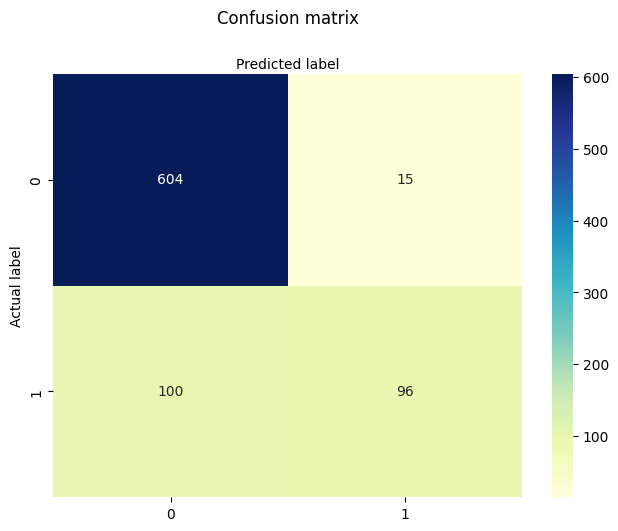

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Although the model attains high overall accuracy and exhibits robust precision in correctly identifying customers who are likely to churn, the moderate recall score suggests that the model misses a portion of the actual churners. This indicates an opportunity to enhance the model's sensitivity and improve its ability to capture the full scope of at-risk customers, which is critical for effective churn mitigation strategies.

### XAI

#### Features Importance

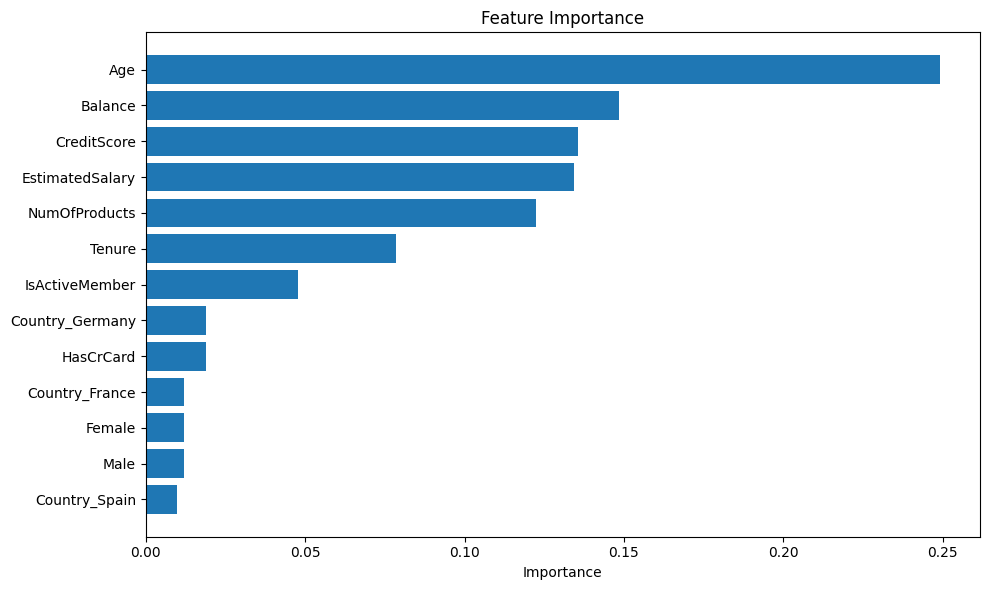

In [ ]:
# Pegando as importâncias das variáveis
importances = best_rf.feature_importances_

# Pegando os nomes das colunas
feature_names = X_train.columns

# Criando um DataFrame para visualizar melhor
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Gráfico para melhor visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Exibindo o DataFrame
df_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
1,Age,0.249248
3,Balance,0.148368
0,CreditScore,0.135713
7,EstimatedSalary,0.134245
4,NumOfProducts,0.122465
2,Tenure,0.078583
6,IsActiveMember,0.047830
11,Country_Germany,0.019015
5,HasCrCard,0.018768
10,Country_France,0.012123


The variable Age was the most influential feature in the model, with an importance score of 0.25. Other significant features, including Balance, CreditScore, EstimatedSalary, and NumOfProducts, exhibited importance scores ranging from 0.10 to 0.15.

#### LIME

By leveraging the LIME library, it is evident that, for the specific instance of customer 590, these features played a critical role in classifying the customer as a potential churner, with a confidence level of 94%.

In [ ]:
!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Criação do explainer para classificação
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Não Churn', 'Churn'],  # ou 0 e 1, conforme o caso
    mode='classification',
    verbose=True
)


In [ ]:
# Índice do exemplo que você quer explicar (ex: amostra 25 do X_test)
i = 590


# Explica a predição feita pelo modelo best_rf
exp = explainer.explain_instance(
    data_row=X_test.values[i],
    predict_fn=best_rf.predict_proba,  # função de predição com probabilidades
    num_features=13  # mostra os 10 atributos mais influentes
)

# Visualiza em notebook
exp.show_in_notebook(show_table=True)

# Ou em HTML (caso queira salvar ou abrir fora do notebook)
# exp.save_to_file('lime_explicacao.html')


Intercept 0.06186740362761692
Prediction_local [1.10674096]
Right: 0.9387755102040817


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### SHAP

While using the SHAP library, I observed that after an update, it started to present compatibility issues with certain scikit-learn models. Therefore, to continue the analysis, we will utilize a customer dataset with churn probabilities to explore, through demographic and behavioral variables, the profiles of these customers."

In [ ]:
!pip install shap

In [ ]:
import shap
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [ ]:
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

# Criar o explainer para classificação
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Negativo', 'Positivo'],
    mode='classification'
)

# Quantas amostras você quer explicar (ex: 10 primeiras do X_test)
num_amostras = 6

# Lista para armazenar explicações
explicacoes = []

# Loop pelas amostras
for i in range(num_amostras):
    exp = explainer.explain_instance(
        data_row=X_test.values[i],
        predict_fn=best_rf.predict_proba,
        num_features=10
    )

    for feature, weight in exp.as_list():
        explicacoes.append({
            'Índice da Amostra': i,
            'Feature': feature,
            'Peso (impacto na predição)': weight
        })

# Criar DataFrame com os resultados
df_explicacoes = pd.DataFrame(explicacoes)

# Exibir as 5 primeiras explicações
print(df_explicacoes.head())

# Exportar para CSV
df_explicacoes.to_csv('lime_explicacoes.csv', index=False)

# Ou para Excel
# df_explicacoes.to_excel('lime_explicacoes.xlsx', index=False)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

   Índice da Amostra                        Feature  \
0                  0  0.00 < IsActiveMember <= 1.00   
1                  0             0.19 < Age <= 0.27   
2                  0        Country_Germany <= 0.00   
3                  0       0.00 < HasCrCard <= 1.00   
4                  0  0.00 < Country_France <= 1.00   

   Peso (impacto na predição)  
0                   -0.141787  
1                   -0.130640  
2                   -0.047511  
3                   -0.024664  
4                   -0.023649  


In [ ]:
probs = best_rf.predict_proba(X_test)[:, 1]  # pega a probabilidade da classe positiva para todas as amostras

### Probability X Features

In [ ]:
# Adiciona a probabilidade
resultados = X_test.copy()
resultados['Probabilidade_Classe_Positiva'] = best_rf.predict_proba(X_test)[:, 1]

# Adiciona a predição
resultados['Predicao'] = best_rf.predict(X_test)

# Mantém o índice como uma coluna chamada 'ID'
resultados['ID'] = resultados.reset_index().index

# Reorganiza as colunas (opcional)
cols = ['ID', 'Probabilidade_Classe_Positiva', 'Predicao'] + X_test.columns.tolist()
resultados = resultados[cols]

# Ordena pela probabilidade
resultados_ordenado = resultados.sort_values(by='Probabilidade_Classe_Positiva', ascending=False)
resultados_ordenado.head(20)


,ID,Probabilidade_Classe_Positiva,Predicao,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Female,Male,Country_France,Country_Germany,Country_Spain
1265,526,0.972789,1.0,0.368,0.500000,0.8,0.458078,0.666667,1.0,0.0,0.610399,0.0,1.0,1,0,0
5137,558,0.947522,1.0,0.696,0.445946,0.6,0.568404,1.000000,1.0,0.0,0.785821,0.0,1.0,1,0,0
1993,590,0.938776,1.0,0.948,0.567568,0.8,0.527988,0.666667,0.0,0.0,0.765329,0.0,1.0,0,1,0
3152,109,0.925170,1.0,0.588,0.297297,0.9,0.540270,1.000000,1.0,0.0,0.385339,0.0,1.0,1,0,0
2721,309,0.921769,1.0,0.428,0.351351,0.3,0.436984,0.666667,1.0,1.0,0.523661,0.0,1.0,0,1,0
4520,513,0.914540,1.0,0.604,0.378378,1.0,0.474630,0.666667,1.0,0.0,0.757506,0.0,1.0,0,1,0
4732,691,0.913199,1.0,0.576,0.472973,0.1,0.486174,0.000000,1.0,0.0,0.083247,1.0,0.0,0,1,0
4869,602,0.911565,1.0,0.638,0.432432,0.4,0.590561,0.666667,1.0,1.0,0.624432,0.0,1.0,1,0,0
6104,758,0.908893,1.0,0.772,0.432432,0.9,0.455390,0.000000,1.0,0.0,0.926933,0.0,1.0,0,1,0
5922,628,0.906463,1.0,0.410,0.351351,0.3,0.412747,0.666667,1.0,0.0,0.302674,1.0,0.0,1,0,0


In [ ]:
# resultados_denormalized = resultados_ordenado.copy()
# columns_to_denormalize  = resultados_denormalized.iloc[:, 3:].columns
# resultados_denormalized[columns_to_denormalize] = scaler.inverse_transform(resultados_denormalized[columns_to_denormalize])


<Axes: >

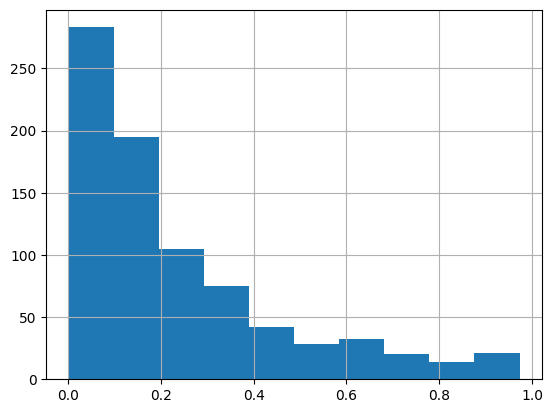

In [ ]:
resultados_ordenado['Probabilidade_Classe_Positiva'].hist()

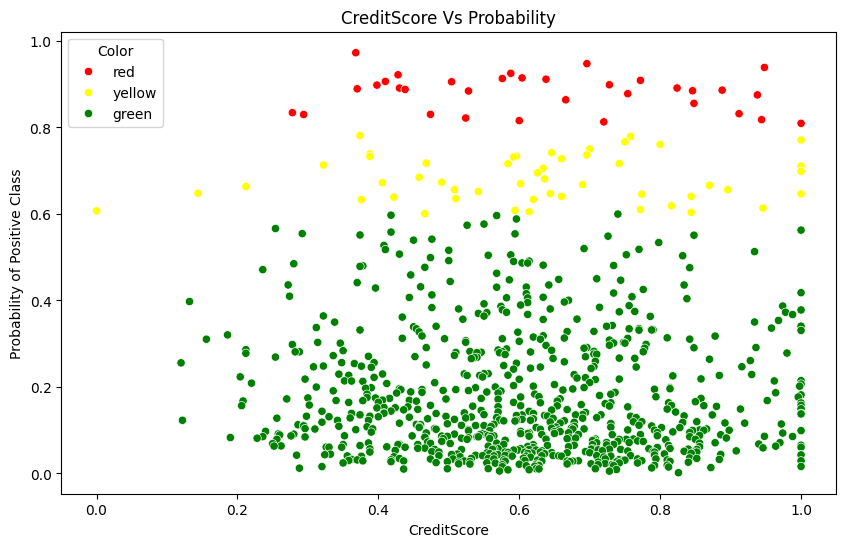

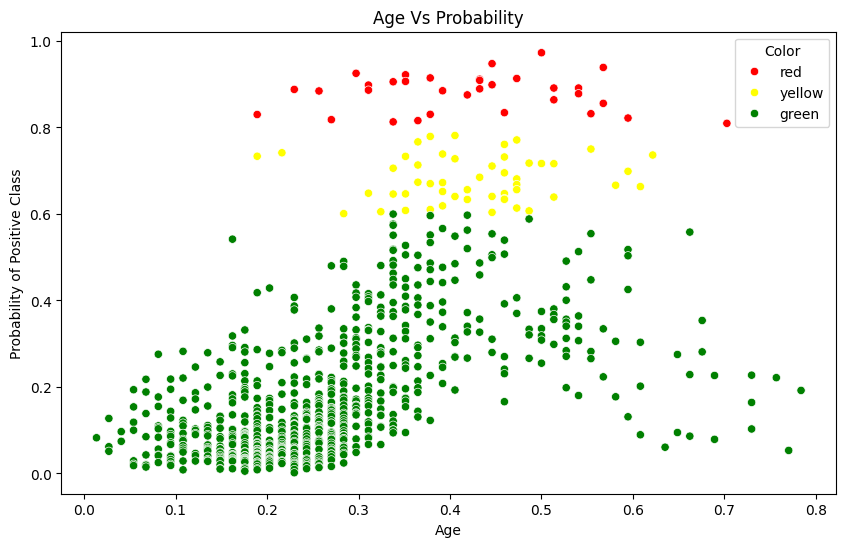

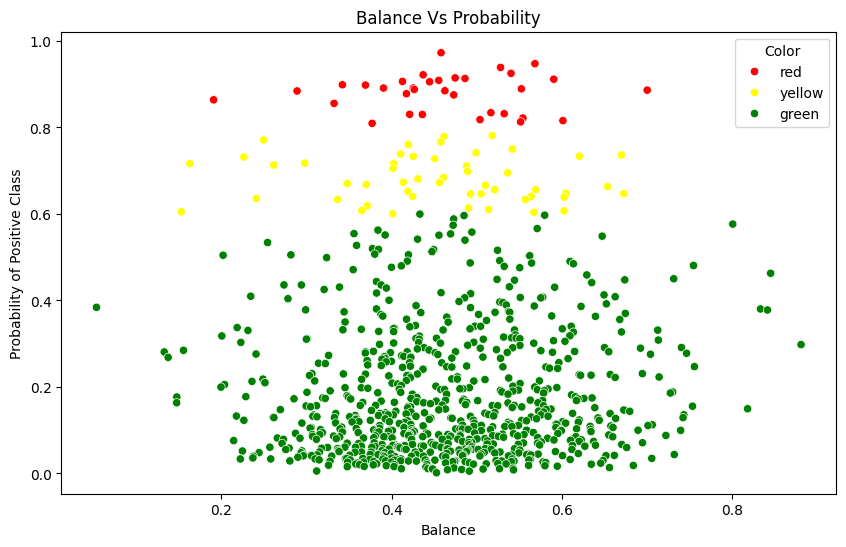

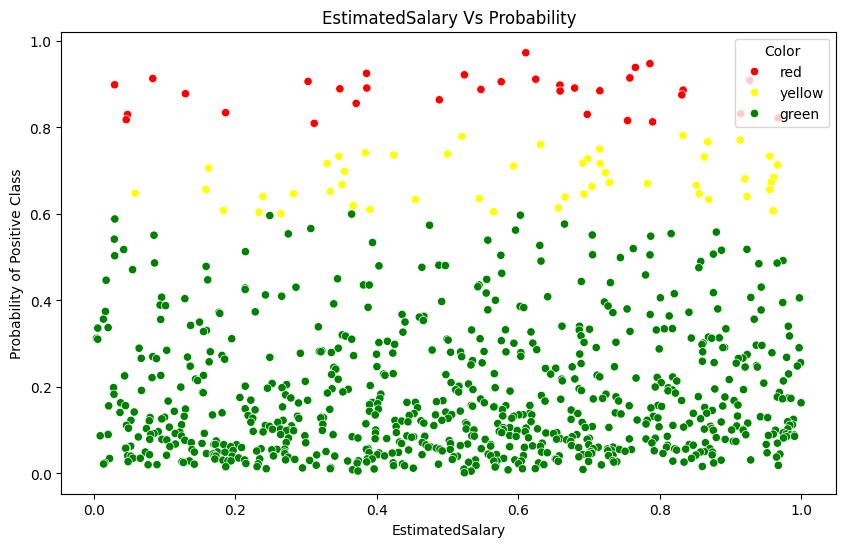

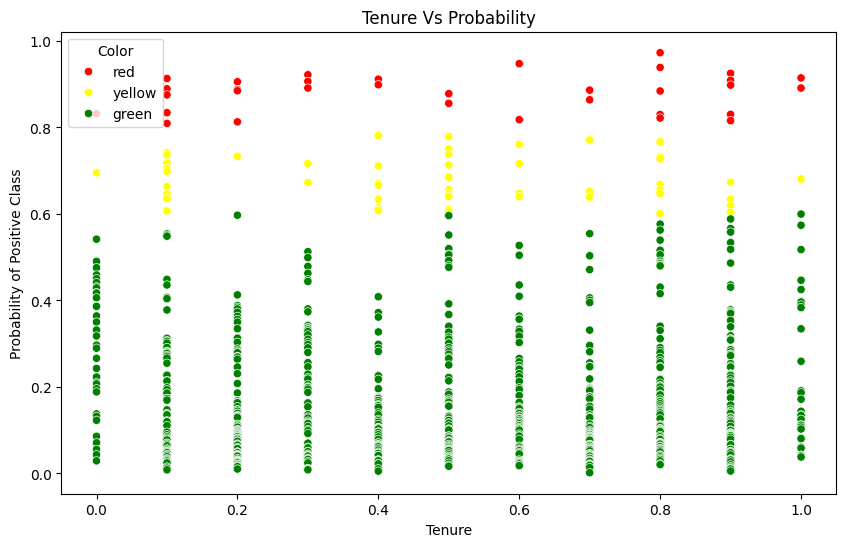

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create color categories based on 'Probabilidade_Classe_Positiva'
def get_color(probability):
    if probability >= 0.8:
        return 'red'
    elif 0.6 <= probability < 0.8:
        return 'yellow'
    else:
        return 'green'

resultados_ordenado['Color'] = resultados_ordenado['Probabilidade_Classe_Positiva'].apply(get_color)

# List of columns to plot against 'Probabilidade_Classe_Positiva'
features_to_plot = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
# Create scatter plots for each feature
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=resultados_ordenado, x=feature, y='Probabilidade_Classe_Positiva', hue='Color', palette={'red': 'red', 'yellow': 'yellow', 'green': 'green'})

    plt.title(f'{feature} Vs Probability')
    plt.xlabel(feature)
    plt.ylabel('Probability of Positive Class')
    plt.show()

<Figure size 1000x700 with 0 Axes>

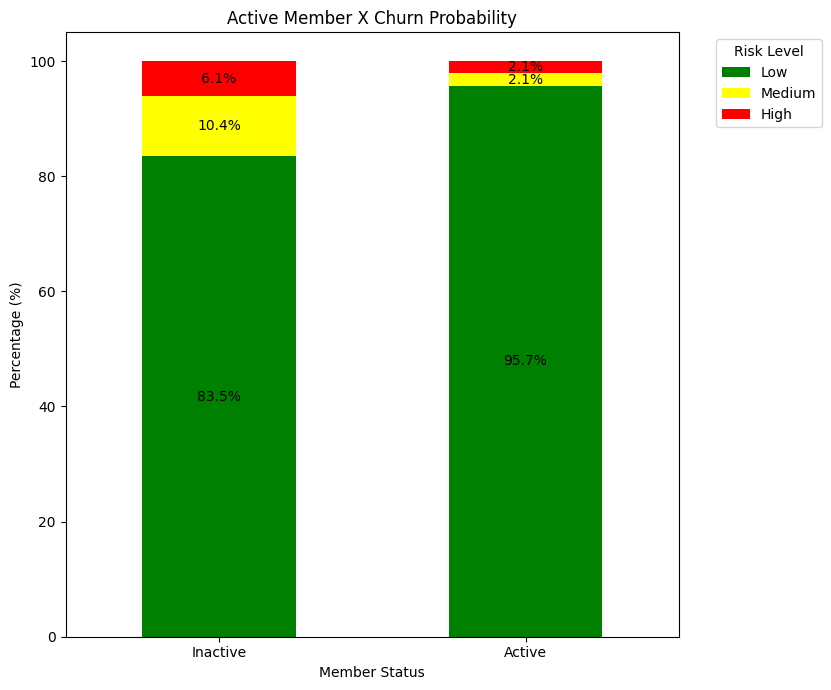

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Importa o pandas para usar pd.crosstab

# Certifique-se de que a coluna 'Color' está criada com base nas probabilidades
# (Você pode manter a função get_color e a linha que a aplica)
def get_color(probability):
    if probability >= 0.8:
        return 'red'
    elif 0.6 <= probability < 0.8:
        return 'yellow'
    else:
        return 'green'

if 'Color' not in resultados_ordenado.columns:
    resultados_ordenado['Color'] = resultados_ordenado['Probabilidade_Classe_Positiva'].apply(get_color)


# Cria uma tabela de frequência cruzada para contar as ocorrências de cada categoria de cor por IsActiveMember
crosstab_data = pd.crosstab(resultados_ordenado['IsActiveMember'], resultados_ordenado['Color'])

# Calcula as porcentagens dentro de cada grupo de IsActiveMember
crosstab_data_percent = crosstab_data.div(crosstab_data.sum(axis=1), axis=0) * 100

# Renomeia os índices para melhor leitura no gráfico
crosstab_data_percent.index = crosstab_data_percent.index.map({0: 'Inactive', 1: 'Active'})

# Ordena as colunas para garantir a ordem das cores no gráfico (opcional, mas recomendado)
order = ['green', 'yellow', 'red']
crosstab_data_percent = crosstab_data_percent[order]

# Cria o gráfico de barras empilhadas
plt.figure(figsize=(10, 7))
ax = crosstab_data_percent.plot(kind='bar', stacked=True, figsize=(10, 7), color={'green': 'green', 'yellow': 'yellow', 'red': 'red'}) # Atribui o plot a uma variável 'ax' para manipular a legenda

# Adiciona rótulos e título
plt.title('Active Member X Churn Probability')
plt.xlabel('Member Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0) # Mantém os rótulos do eixo X na horizontal

# Define os rótulos desejados para a legenda na ordem correta das cores
legend_labels = ['Low', 'Medium', 'High']
plt.legend(title='Risk Level', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
# --------------------

# Adiciona os valores das porcentagens nas barras (opcional)
for container in ax.containers: # Usa 'ax.containers' já que o plot foi atribuído a 'ax'
    for rect in container:
        height = rect.get_height()
        width = rect.get_width()
        x, y = rect.get_xy()
        if height > 0: # Apenas adiciona texto se a barra não estiver vazia
            plt.text(x + width/2., y + height/2., f'{height:.1f}%', ha='center', va='center', color='black')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para acomodar a legenda
plt.show()

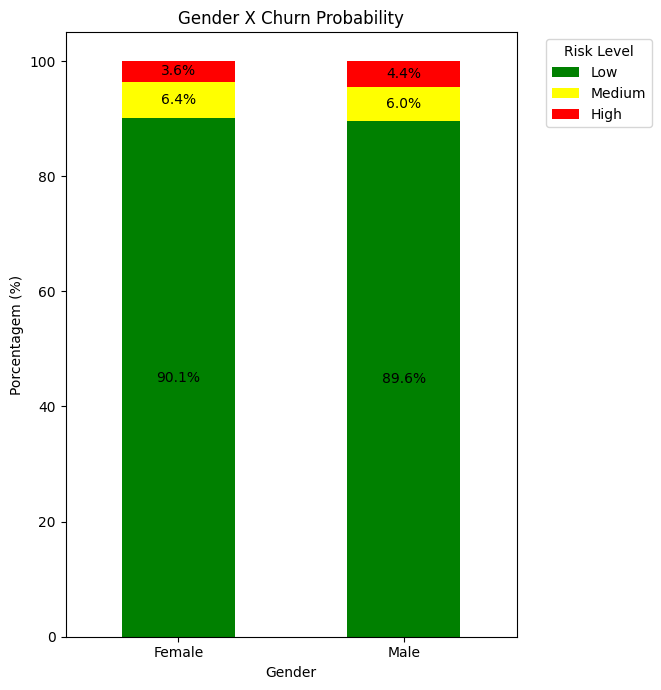

In [ ]:
# Define a ordem das cores para o gráfico
order = ['green', 'yellow', 'red']
legend_labels = ['Low', 'Medium', 'High'] # Rótulos para a legenda

# Cria um DataFrame focado em Male e Female onde o valor é 1
# Seleciona as colunas relevantes e filtra para casos onde Male ou Female é 1
df_gender = resultados_ordenado[['Male', 'Female', 'Color']].copy()
df_gender_filtered = df_gender[(df_gender['Male'] == 1) | (df_gender['Female'] == 1)].copy()

# Desempilha (melt) o DataFrame para ter uma coluna de 'Gênero' e outra de 'Valor' (que será 1)
df_gender_melted = df_gender_filtered.melt(id_vars=['Color'], value_vars=['Male', 'Female'], var_name='Gênero', value_name='Valor')

# Filtra para incluir apenas as linhas onde o 'Valor' é 1 (garantindo que são apenas Male ou Female de fato)
df_gender_melted = df_gender_melted[df_gender_melted['Valor'] == 1].copy()

# Cria uma tabela de frequência cruzada para contar as ocorrências de cada categoria de cor por Gênero
crosstab_data = pd.crosstab(df_gender_melted['Gênero'], df_gender_melted['Color'])

# Calcula as porcentagens dentro de cada grupo de Gênero (dividindo pelas linhas)
crosstab_data_percent = crosstab_data.div(crosstab_data.sum(axis=1), axis=0) * 100

# Reordena as colunas (categorias de cor)
crosstab_data_percent = crosstab_data_percent[order]

# Cria o gráfico de barras empilhadas
plt.figure(figsize=(8, 7)) # Tamanho ajustado
ax = crosstab_data_percent.plot(kind='bar', stacked=True, figsize=(8, 7), color={'green': 'green', 'yellow': 'yellow', 'red': 'red'}, ax=plt.gca())


# Adiciona rótulos e título
plt.title('Gender X Churn Probability')
plt.xlabel('Gender')
plt.ylabel('Porcentagem (%)')
plt.xticks(rotation=0) # Mantém os rótulos do eixo X na horizontal

# Define a legenda com os rótulos de risco (Low, Medium, High)
plt.legend(title='Risk Level', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')


# Adiciona os valores das porcentagens nas barras (opcional)
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        width = rect.get_width()
        x, y = rect.get_xy()
        if height > 0: # Apenas adiciona texto se a barra não estiver vazia
            plt.text(x + width/2., y + height/2., f'{height:.1f}%', ha='center', va='center', color='black')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para acomodar a legenda
plt.show()

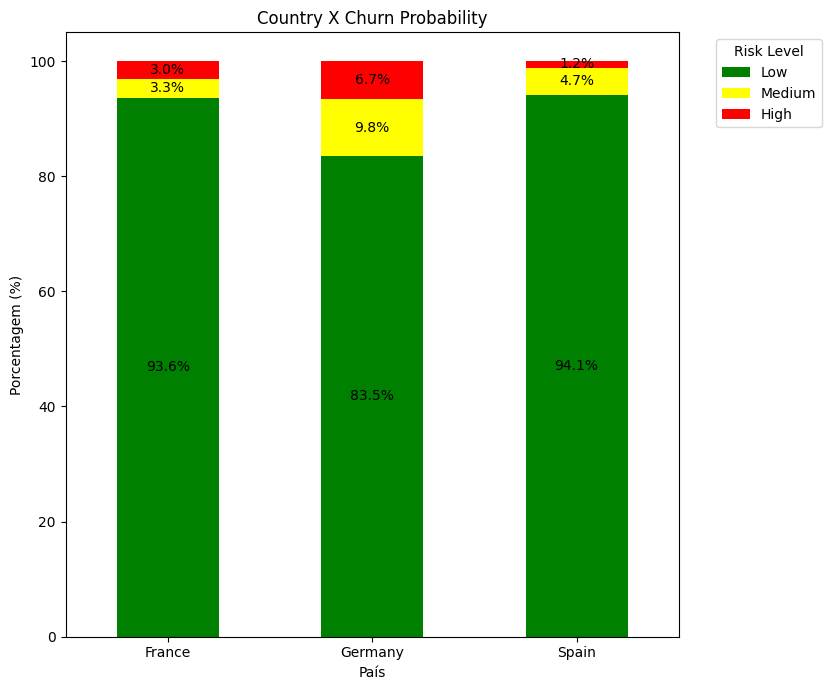

In [ ]:
# Define a ordem das cores para o gráfico
order = ['green', 'yellow', 'red']
legend_labels = ['Low', 'Medium', 'High'] # Rótulos para a legenda

# Define as variáveis de país para incluir na análise
country_columns = ['Country_France', 'Country_Germany', 'Country_Spain']

# Cria um DataFrame focado nos países onde o valor é 1
# Seleciona as colunas relevantes e filtra para casos onde uma das colunas de país é 1
df_country = resultados_ordenado[country_columns + ['Color']].copy()
df_country_filtered = df_country[(df_country['Country_France'] == 1) |
                                (df_country['Country_Germany'] == 1) |
                                (df_country['Country_Spain'] == 1)].copy()

# Desempilha (melt) o DataFrame para ter uma coluna de 'País' e outra de 'Valor' (que será 1)
df_country_melted = df_country_filtered.melt(id_vars=['Color'], value_vars=country_columns, var_name='País', value_name='Valor')

# Filtra para incluir apenas as linhas onde o 'Valor' é 1 (garantindo que são apenas clientes de cada país de fato)
df_country_melted = df_country_melted[df_country_melted['Valor'] == 1].copy()

# Remove o prefixo "Country_" do nome do país para o rótulo do gráfico
df_country_melted['País'] = df_country_melted['País'].str.replace('Country_', '')


# Cria uma tabela de frequência cruzada para contar as ocorrências de cada categoria de cor por País
crosstab_data = pd.crosstab(df_country_melted['País'], df_country_melted['Color'])

# Calcula as porcentagens dentro de cada grupo de País (dividindo pelas linhas)
crosstab_data_percent = crosstab_data.div(crosstab_data.sum(axis=1), axis=0) * 100

# Reordena as colunas (categorias de cor)
crosstab_data_percent = crosstab_data_percent[order]

# Cria o gráfico de barras empilhadas
plt.figure(figsize=(10, 7)) # Tamanho ajustado
ax = crosstab_data_percent.plot(kind='bar', stacked=True, figsize=(10, 7), color={'green': 'green', 'yellow': 'yellow', 'red': 'red'}, ax=plt.gca())


# Adiciona rótulos e título
plt.title('Country X Churn Probability')
plt.xlabel('País')
plt.ylabel('Porcentagem (%)')
plt.xticks(rotation=0) # Mantém os rótulos do eixo X na horizontal

# Define a legenda com os rótulos de risco (Low, Medium, High)
plt.legend(title='Risk Level', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')


# Adiciona os valores das porcentagens nas barras (opcional)
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        width = rect.get_width()
        x, y = rect.get_xy()
        if height > 0: # Apenas adiciona texto se a barra não estiver vazia
            plt.text(x + width/2., y + height/2., f'{height:.1f}%', ha='center', va='center', color='black')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para acomodar a legenda
plt.show()

<Figure size 1000x700 with 0 Axes>

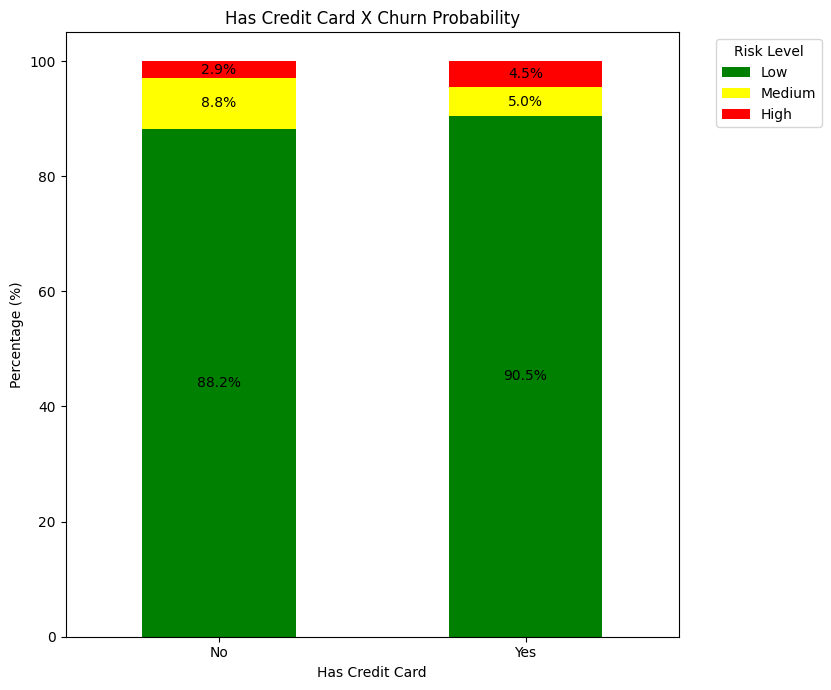

In [ ]:
# Cria uma tabela de frequência cruzada para contar as ocorrências de cada categoria de cor por IsActiveMember
crosstab_data = pd.crosstab(resultados_ordenado['HasCrCard'], resultados_ordenado['Color'])

# Calcula as porcentagens dentro de cada grupo de IsActiveMember
crosstab_data_percent = crosstab_data.div(crosstab_data.sum(axis=1), axis=0) * 100

# Renomeia os índices para melhor leitura no gráfico
crosstab_data_percent.index = crosstab_data_percent.index.map({0: 'No', 1: 'Yes'})

# Ordena as colunas para garantir a ordem das cores no gráfico (opcional, mas recomendado)
order = ['green', 'yellow', 'red']
crosstab_data_percent = crosstab_data_percent[order]

# Cria o gráfico de barras empilhadas
plt.figure(figsize=(10, 7))
ax = crosstab_data_percent.plot(kind='bar', stacked=True, figsize=(10, 7), color={'green': 'green', 'yellow': 'yellow', 'red': 'red'}) # Atribui o plot a uma variável 'ax' para manipular a legenda

# Adiciona rótulos e título
plt.title('Has Credit Card X Churn Probability')
plt.xlabel('Has Credit Card')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0) # Mantém os rótulos do eixo X na horizontal

# --- ALTERAÇÃO AQUI ---
# Define os rótulos desejados para a legenda na ordem correta das cores
legend_labels = ['Low', 'Medium', 'High']
plt.legend(title='Risk Level', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
# --------------------

# Adiciona os valores das porcentagens nas barras (opcional)
for container in ax.containers: # Usa 'ax.containers' já que o plot foi atribuído a 'ax'
    for rect in container:
        height = rect.get_height()
        width = rect.get_width()
        x, y = rect.get_xy()
        if height > 0: # Apenas adiciona texto se a barra não estiver vazia
            plt.text(x + width/2., y + height/2., f'{height:.1f}%', ha='center', va='center', color='black')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para acomodar a legenda
plt.show()

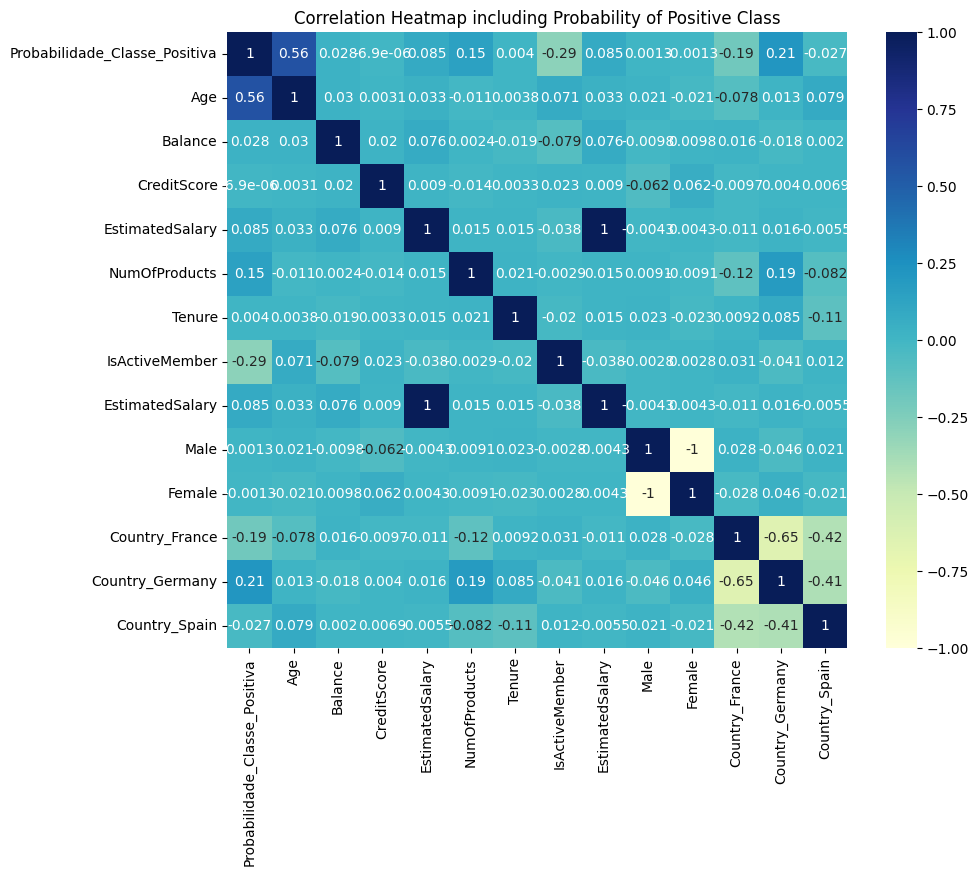

In [ ]:
# Calculate the correlation matrix including 'Probabilidade_Classe_Positiva'
correlation_matrix = resultados_ordenado[['Probabilidade_Classe_Positiva', 'Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure', 'IsActiveMember', 'EstimatedSalary', 'Male', 'Female', 'Country_France', 'Country_Germany', 'Country_Spain']].corr()

# Create the heatmap
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Heatmap including Probability of Positive Class')
plt.show()

In [ ]:
correlation_matrix.sort_values(by='Probabilidade_Classe_Positiva', ascending=False)

,Probabilidade_Classe_Positiva,Age,Balance,CreditScore,EstimatedSalary,NumOfProducts,Tenure,IsActiveMember,EstimatedSalary,Male,Female,Country_France,Country_Germany,Country_Spain
Probabilidade_Classe_Positiva,1.000000,0.563962,0.027550,-0.000007,0.084807,0.146435,0.004033,-0.294966,0.084807,0.001296,-0.001296,-0.187650,0.211535,-0.026813
Age,0.563962,1.000000,0.030398,0.003137,0.033300,-0.011259,0.003849,0.070522,0.033300,0.020635,-0.020635,-0.078442,0.013183,0.078970
Country_Germany,0.211535,0.013183,-0.018240,0.004006,0.015686,0.187449,0.085082,-0.040868,0.015686,-0.046077,0.046077,-0.654721,1.000000,-0.407488
NumOfProducts,0.146435,-0.011259,0.002391,-0.013657,0.015326,1.000000,0.021455,-0.002923,0.015326,0.009054,-0.009054,-0.118348,0.187449,-0.081673
EstimatedSalary,0.084807,0.033300,0.076008,0.009040,1.000000,0.015326,0.014779,-0.038387,1.000000,-0.004314,0.004314,-0.010983,0.015686,-0.005530
EstimatedSalary,0.084807,0.033300,0.076008,0.009040,1.000000,0.015326,0.014779,-0.038387,1.000000,-0.004314,0.004314,-0.010983,0.015686,-0.005530
Balance,0.027550,0.030398,1.000000,0.019503,0.076008,0.002391,-0.019456,-0.079095,0.076008,-0.009784,0.009784,0.016473,-0.018240,0.001959
Tenure,0.004033,0.003849,-0.019456,0.003268,0.014779,0.021455,1.000000,-0.020116,0.014779,0.022887,-0.022887,0.009237,0.085082,-0.113130
Male,0.001296,0.020635,-0.009784,-0.061975,-0.004314,0.009054,0.022887,-0.002765,-0.004314,1.000000,-1.000000,0.028055,-0.046077,0.021328
CreditScore,-0.000007,0.003137,0.019503,1.000000,0.009040,-0.013657,0.003268,0.022647,0.009040,-0.061975,0.061975,-0.009697,0.004006,0.006915
